In [62]:
import pickle
import numpy as np
from tqdm import tqdm

In [63]:
embs = pickle.load(open('Data/embeddings.pkl', 'rb'))

In [64]:
len(embs['descriptions'])

488897

In [65]:
len(embs['embeddings'])

488897

In [66]:
embs['embeddings'].shape

(488897, 768)

In [67]:
embs['embeddings'][0].shape

(768,)

In [68]:
embs['descriptions'][0]

'Symbol: ENG1 Type: protein Organism: Rhizomucor miehei Description: Cleaves internal linkages in 1,3-beta-glucan. Tris binds the active site and may act as an inhibitor. Belongs to the glycosyl hydrolase 81 family.'

In [69]:
embs['descriptions'][10]

'Symbol: DAHP1 Type: protein Organism: Petunia hybrida Description: Involved in the production of volatile organic compounds (VOCs), including floral volatile benzenoids and phenylpropanoids (FVBP), in flowers of fragrant cultivars (e.g. cv. Mitchell and cv. V26), scent attracting pollinators (e.g. the night-active hawkmoth pollinator Manduca sexta) . Catalyzes an aldol-like condensation reaction between phosphoenolpyruvate (PEP) and D-erythrose 4-phosphate (E4P) to generate 3-deoxy-D-arabino-heptulosonate 7-phosphate (DAH7P) and inorganic phosphate (By similarity). Binds 1 divalent metal cation per subunit that could be manganese. Metabolic intermediate biosynthesis; chorismate biosynthesis; chorismate from D-erythrose 4-phosphate and phosphoenolpyruvate: step 1/7. Homodimer. Mostly expressed in flowers, especially in petal limbs and tubes, and, to a lower extent, in roots, stems, stigmas, anthers, leaves and sepals. During floral development, accumulates to highest levels during open

In [70]:
no_symbol = 0
no_type = 0
no_organism = 0
no_description = 0
for i, des in enumerate(embs['descriptions']):
    if 'Symbol' not in des:
        no_symbol += 1
    if 'Organism' not in des:
        no_organism += 1
    if 'Description' not in des:
        no_description += 1
    if 'Type' not in des:
        no_type += 1
print('No symbol: ', no_symbol)
print('No organism: ', no_organism)
print('No description: ', no_description)
print('No type: ', no_type)

No symbol:  0
No organism:  0
No description:  0
No type:  0


In [74]:
from collections import defaultdict
import pandas as pd

res = defaultdict(dict)
organisms = set()
entities = set()
types = set()
meta = []
for i, des in enumerate(embs['descriptions']):
    symbol = des.split('Type')[0].split(':')[-1].strip()
    type = des.split('Organism')[0].split(':')[-1].strip()
    organism = des.split('Description')[0].split(':')[-1].strip()
    description = des.split('Description')[-1].strip().strip(':')
    
    res[i]['Symbol'] = symbol
    res[i]['Type'] = type
    res[i]['Organism'] = organism
    res[i]['Description'] = description
    res[i]['Embedding'] = embs['embeddings'][i]

    organisms.add(organism)
    entities.add(organism + '_' + symbol)
    types.add(type)
    meta.append([symbol, type, organism, description])

with open('Data/embeddings_.pickle', 'wb') as f:
    pickle.dump(res, f)
meta = pd.DataFrame(meta, columns=['Symbol', 'Type', 'Organism', 'Description'])
meta

,Symbol,Type,Organism,Description
0,ENG1,protein,Rhizomucor miehei,"Cleaves internal linkages in 1,3-beta-glucan...."
1,cbh2,protein,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Exocellobiohydrolases (CBH) that catalyzes th...
2,Orco,protein,Ooceraea biroi,Odorant coreceptor which complexes with conve...
3,Bli,protein,Onchocerca volvulus,Serine endoprotease which cleaves substrates ...
4,CCR1,protein,Petunia hybrida,Involved in the latter stages of lignin biosy...
...,...,...,...,...
488892,RPS8,protein,Griffithsia japonica,Belongs to the eukaryotic ribosomal protein e...
488893,ninE,protein,Escherichia phage 933W,Belongs to the ninE family.
488894,AP,protein,Fragaria ananassa,"Interacts with FRAA1E, FRAA2 and FRAA3."
488895,GUCA1ANB,protein,Homo sapiens,Product of a dubious gene prediction.


In [75]:
meta.to_csv('Data/meta_full.csv', index=True)

In [76]:
organism_count = meta.value_counts('Organism')
organisms_to_keep = organism_count[organism_count > 1000].index.to_list()
print(len(organism_count), len(organisms_to_keep))
print(meta.shape)
print(meta[[o in organisms_to_keep for o in meta.Organism]].shape)
meta_to_keep = meta[[o in organisms_to_keep for o in meta.Organism]]
embs_to_keep = meta_to_keep.index.to_list()
print(len(embs_to_keep))

res = pickle.load(open('Data/embeddings_.pickle', 'rb'))
res_to_keep = {
    k: v for k, v in tqdm(res.items()) if k in embs_to_keep
}
pickle.dump(res_to_keep, open('Data/embeddings_1000.pickle', 'wb'))
meta_to_keep.to_csv('Data/meta_1000.csv', index=True)

11145 30
(488897, 4)
(119830, 4)
119830


100%|██████████| 488897/488897 [08:10<00:00, 997.51it/s] 


In [77]:
from tqdm import tqdm
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-sci-base")
tok_lens = []
for i, des in tqdm(enumerate(meta.Description)):
    tok_lens.append(len(tokenizer.tokenize(des, padding=True, truncation=True, return_tensors="pt")))
meta['tok_len'] = tok_lens
meta.to_csv('Data/meta_full__with_tok_len.csv', index=True)

488897it [05:10, 1572.99it/s]


In [78]:
tok_lens = []
for i, des in tqdm(enumerate(meta_to_keep.Description)):
    tok_lens.append(len(tokenizer.tokenize(des, padding=True, truncation=True, return_tensors="pt")))
meta_to_keep['tok_len'] = tok_lens
meta_to_keep.to_csv('Data/meta_1000__with_tok_len.csv', index=True)

119830it [01:33, 1278.55it/s]
C:\Users\wuqi0\AppData\Local\Temp\ipykernel_16144\847508319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_to_keep['tok_len'] = tok_lens


Filtered organisms with less than 1000 proteins

In [79]:
meta_to_keep

,Symbol,Type,Organism,Description,tok_len
6,pezo-1,protein,Caenorhabditis elegans,Pore-forming subunit of a mechanosensitive no...,344
28,Auts2,protein,Mus musculus,Component of a Polycomb group (PcG) multiprot...,512
29,CYP2D7,protein,Homo sapiens,May be responsible for the metabolism of many...,101
31,Iqcj-Schip1,protein,Mus musculus,May play a role in action potential conductio...,292
32,msl3,protein,Mycobacterium tuberculosis (strain ATCC 25618 ...,Polyketide synthase involved in the biosynthe...,262
...,...,...,...,...,...
488870,LINC00312,protein,Homo sapiens,Product of a dubious CDS prediction. May be a...,16
488878,yjgW,protein,Escherichia coli (strain K12),Could be the product of a pseudogene.,9
488885,yubL,protein,H7,Belongs to the UPF0401 family.,9
488895,GUCA1ANB,protein,Homo sapiens,Product of a dubious gene prediction.,8


In [80]:
res = pickle.load(open('Data/embeddings_1000.pickle', 'rb'))

In [81]:
embs = np.array([v['Embedding'] for k, v in res.items()])
embs.shape # (119830, 768)

(119830, 768)

Tokenized Description Density Plot

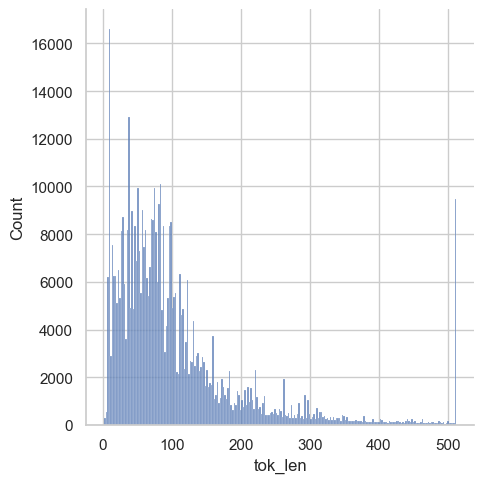

In [84]:
import seaborn as sns
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(10,10)})
sns.displot(meta, x="tok_len")

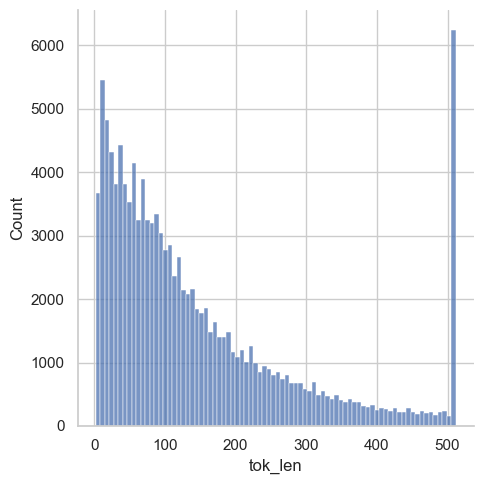

In [85]:
sns.displot(meta_to_keep, x="tok_len")

In [87]:
embs.shape

(119830, 768)

In [88]:
import umap
reducer = umap.UMAP(
    n_neighbors=15,
    metric='euclidean', # 'cosine', 'euclidean'
    # densmap=True
)
umap_embeddings = reducer.fit_transform(embs)

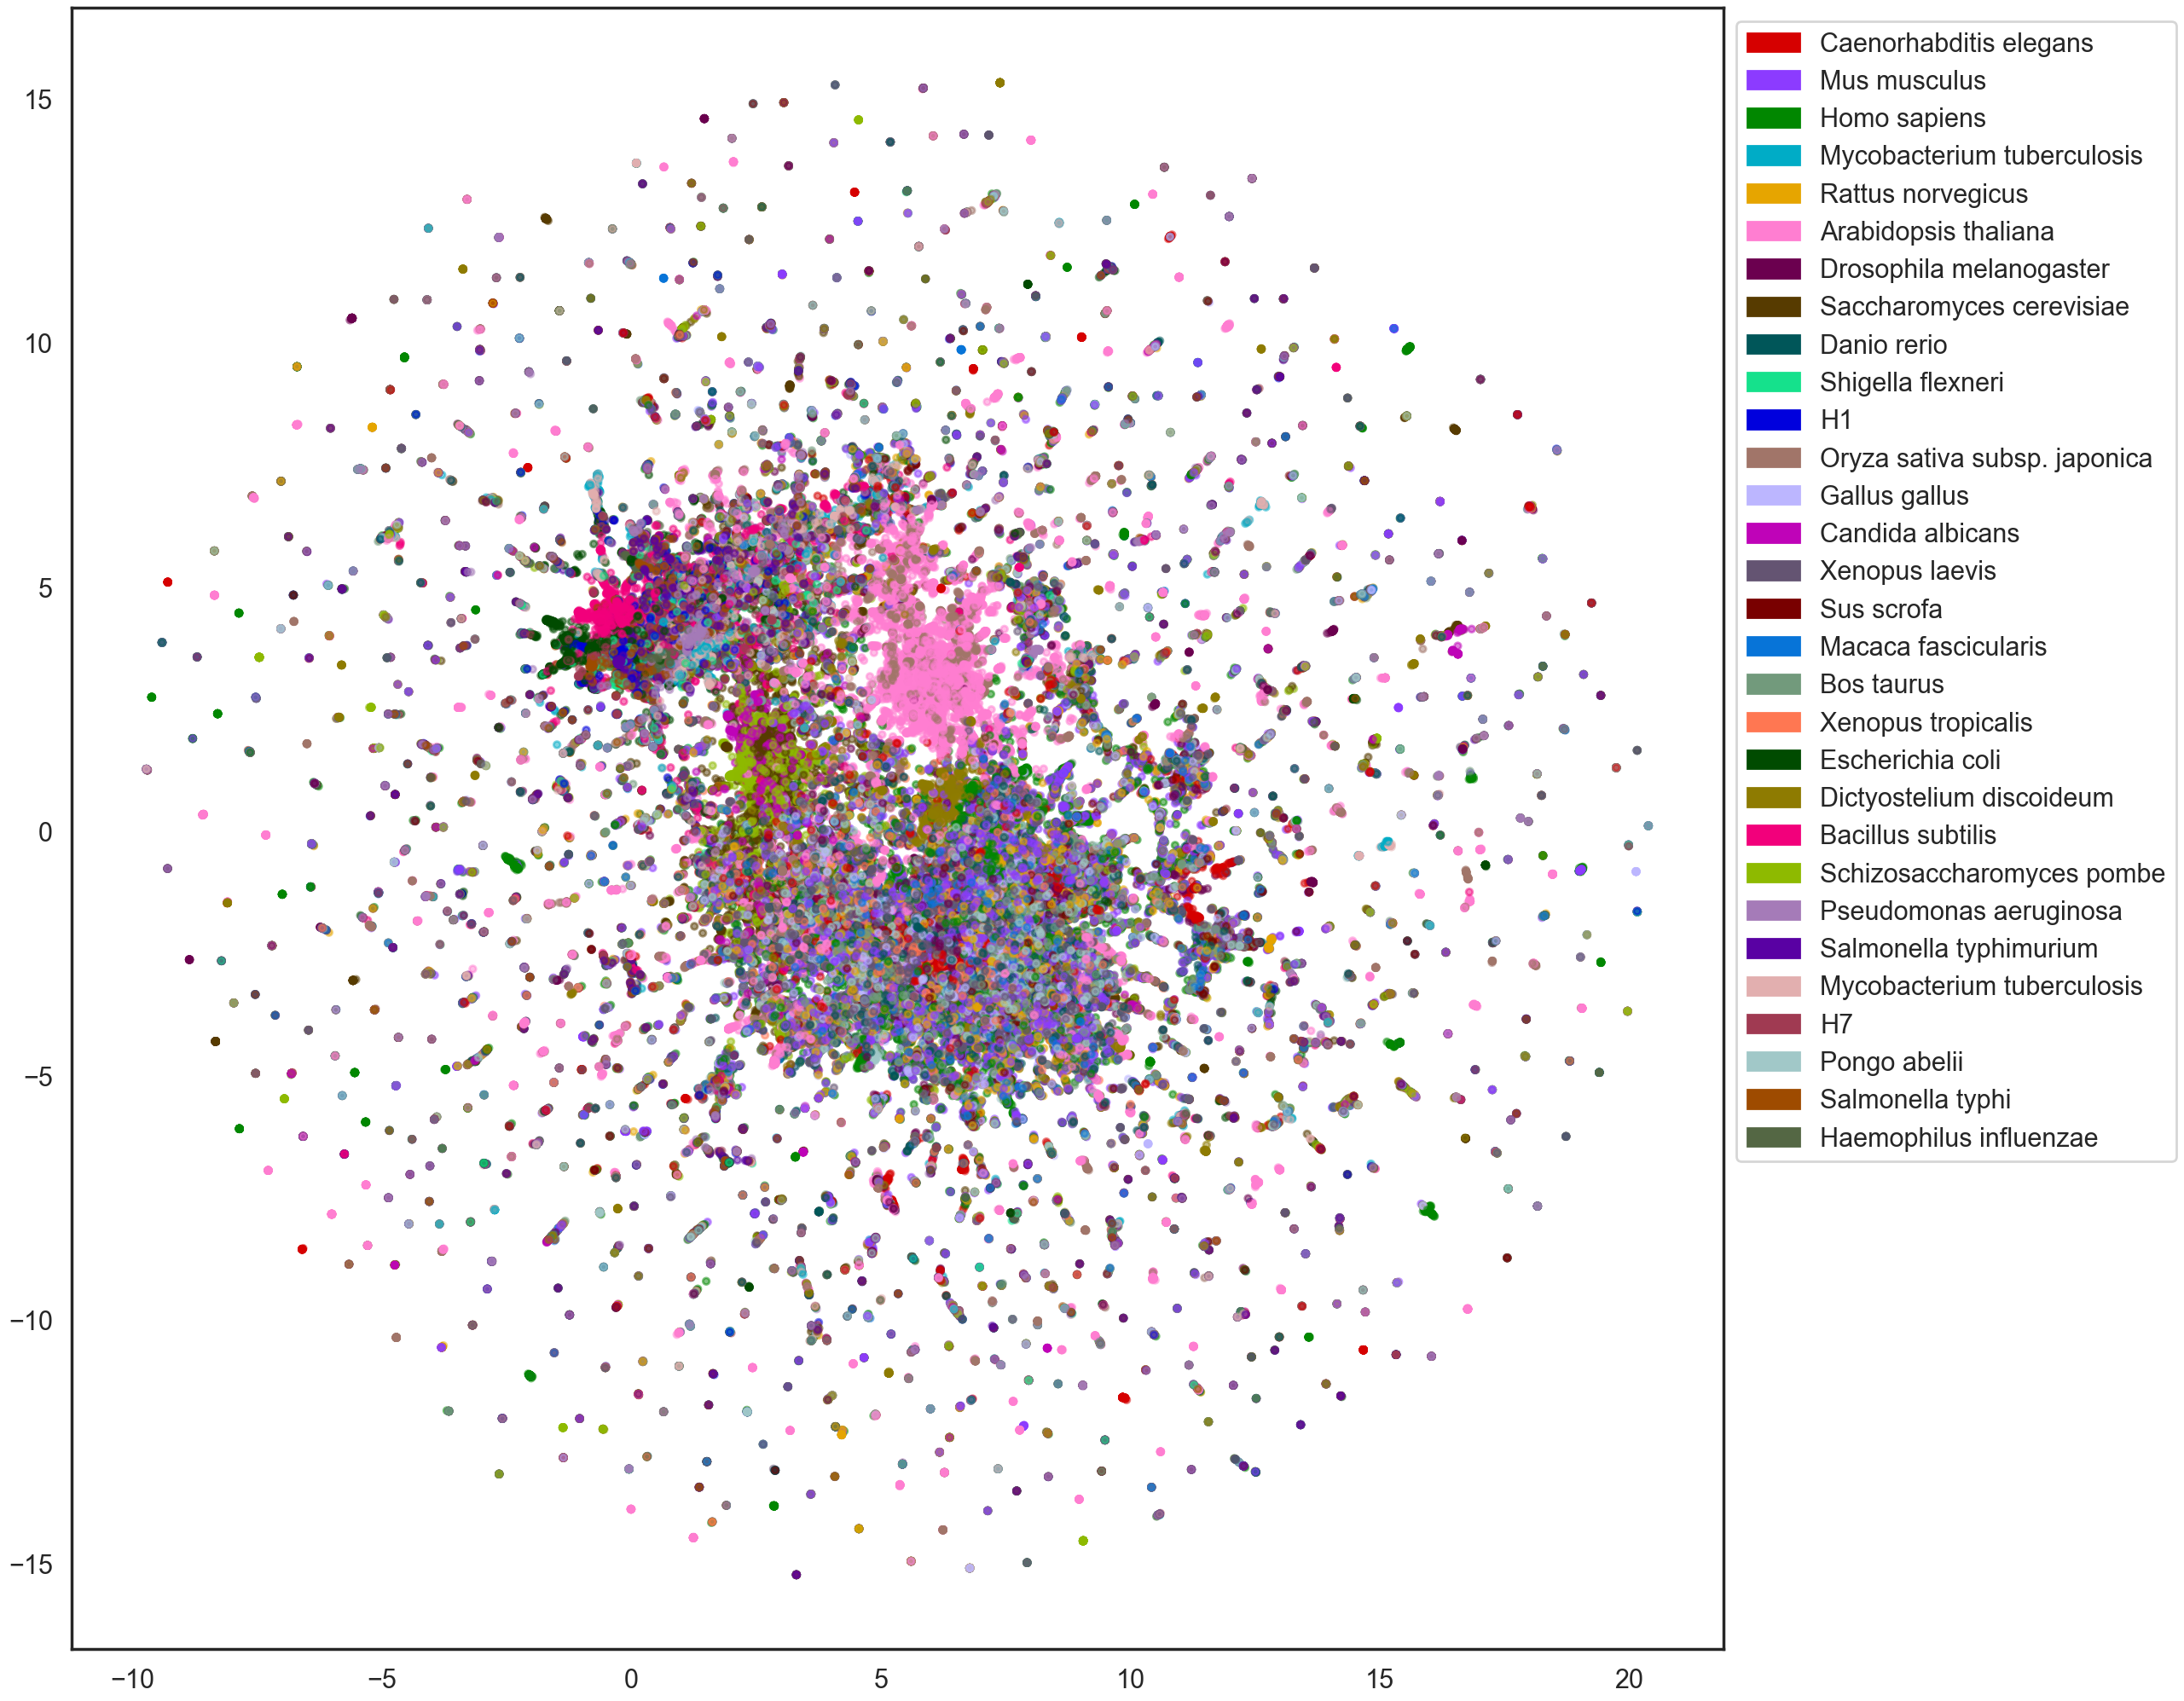

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import re 


sns.set(style='white', context='poster', rc={'figure.figsize':(25,25)})

palette = sns.color_palette(cc.glasbey_dark, n_colors=30) # glasbey_bw_minc_20
organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}

plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=[palette[x] for x in meta_to_keep.Organism.map(organism_mapper)],
    s=30,
    alpha=0.5,
)

import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color=palette[i], label=re.sub("[\(\[].*?[\)\]]", "", o).strip()) for i, o in enumerate(meta_to_keep.Organism.unique())
]
plt.legend(handles=patches, bbox_to_anchor=(1, 1))
plt.show()


In [90]:
umap_embeddings.shape

(119830, 2)

In [91]:
umap_emb = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}
umap_emb_labels = pd.DataFrame(meta_to_keep.Organism)

In [93]:
umap_emb.to_csv('Outputs/corrected_1/umap_embeddings_1.tsv', index=False, header=False, sep='\t')
meta_to_keep.to_csv('Outputs/corrected_1/umap_embeddings_labels_1.tsv', index=False, header=True, sep='\t')

In [94]:
umap_emb.shape

(119830, 2)

In [96]:
tensorflow_projector_config = {
  "embeddings": [
    {
      "tensorName": "vis",
      "tensorShape": [119830, 2],
      "tensorPath": "https://raw.githubusercontent.com/qwu01/NLP_Projects/master/Outputs/corrected_1/umap_embeddings_1.tsv",
      "metadataPath": "https://raw.githubusercontent.com/qwu01/NLP_Projects/master/Outputs/corrected_1/umap_embeddings_labels_1.tsv"
    }
  ]
}
import json
json.dump(tensorflow_projector_config, open('Outputs/corrected_1/tensorflow_projector_config_1.json', 'w'))

In [39]:
# import umap
# reducer = umap.UMAP(
#     n_neighbors=15,
#     metric='cosine', # 'cosine', 'euclidean'
#     # densmap=True
# )
# umap_embeddings = reducer.fit_transform(embs)

# umap_emb = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
# organism_mapper = {o:i for i,o in enumerate(meta_to_keep.Organism.unique())}
# umap_emb_labels = meta_to_keep
# umap_emb.to_csv('Outputs/umap_embeddings_1_cos.tsv', index=False, header=False, sep='\t')
# umap_emb_labels.to_csv('Outputs/umap_embeddings_labels_1_cos.tsv', index=False, header=True, sep='\t')